# CéCI Training Days
## Dynamical Systems in Julia

The goal of this short example is to showcase how to define and simulate dynamical systems in Julia. By the end you will have learned

- How to specify dynamical systems symbolically, and by hand
- How to solve an ODE using the [OrdinaryDiffEq](https://docs.sciml.ai/OrdinaryDiffEq/stable/) package
- How to estimate model parameters from data using Bayesian Estimation with the [Turing](https://turinglang.org/) package

In [1]:
using Catalyst
using ModelingToolkit
using OrdinaryDiffEq
using Plots
using StatsPlots
using Latexify
using Turing

## Defining Systems symbolically

We'll start by using [ModelingToolkit](https://docs.sciml.ai/ModelingToolkit/stable/) to define the famous Lorenz system. The process starts by a symbolic description of the problem.

In [2]:
@parameters σ ρ β
@independent_variables t
@variables x(t) y(t) z(t)
D = Differential(t)
eqs = [
    D(x) ~ σ*(y-x),
   	D(y) ~ x*(ρ-z)-y,
   	D(z) ~ x*y - β*z
]
@named lorenz = ODESystem(eqs, t)

Model lorenz:
Equations (3):
  3 standard: see equations(lorenz)
Unknowns (3): see unknowns(lorenz)
  x(t)
  y(t)
  z(t)
Parameters (3): see parameters(lorenz)
  σ
  ρ
  β

So far, the lorenz system is purely symbolic, which has the added benefit of being able to render the equations in LaTeX as above! The next step before simulating it is defining values for our initial condition and parameters.

In [3]:
u0 = [
		x => 0.0,
      	y => 0.5,
      	z => 0.5
]

p  = (
	ρ => 28.0,
  	σ => 10.0,
  	β => 8/3
)

(ρ => 28.0, σ => 10.0, β => 2.6666666666666665)

Simulating our system is a two step process. After defining our timespan of integration, we first create an `ODEProblem`, which describes an ODE + initial conditions and parameters, and then pass it to the `solve` function to compute the solution of our problem. The second argument to solve is the solver we want to use (`Tsit5` is a 4-5 order Runge-Kutta scheme which is generally a good default choice for non-stiff problems)

In [4]:
tspan = (0.0,50.0)

lorenz_sys = structural_simplify(lorenz)
prob = ODEProblem(lorenz_sys, u0, tspan, p)
sol = solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 637-element Vector{Float64}:
  0.0
  0.0002822781105531348
  0.0031050592160844826
  0.010507080564012427
  0.022131343453753675
  0.03701367047739376
  0.056744179391180524
  0.08136791807736435
  0.11229294783322678
  0.15031357596681572
  ⋮
 49.50022474365258
 49.58493475392495
 49.65919773436262
 49.71890311122139
 49.776048196641895
 49.828423753138146
 49.893919083609504
 49.95715092825225
 50.0
u: 637-element Vector{Vector{Float64}}:
 [0.0, 0.5, 0.5]
 [0.0014092065527061973, 0.49986435280614483, 0.4996238702605737]
 [0.015269651525170564, 0.4991047661015433, 0.49588888263206127]
 [0.0498553717954821, 0.5020740445925148, 0.4863169602888824]
 [0.1003544944558553, 0.5202749469678244, 0.47191512882078845]
 [0.1613751588906841, 0.5659314947410294, 0.45459328345838335]
 [0.24220457981079888, 0.6634375844419029, 0.4336789843824868]
 [0.3536253973898164, 0.8463098218251399, 0.4114667672269122]
 [0.529432701119

The DifferentialEquations package includes some additional methods for `Plots` to visualize the solution of an ODE.

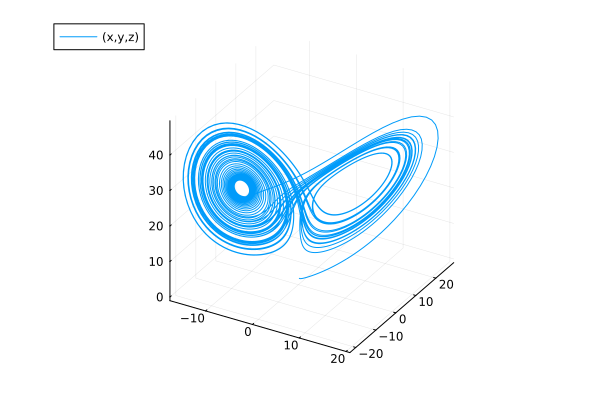

In [5]:
plot(sol, idxs=(x,y,z))

## Defining Systems by hand

While defining systems symbolically is cool, this can be tedious for large systems, and sometimes you just want full control over how your ODE function is defined. To that end, we will now define another famous system, the Brusselator by hand.

The Brusselator equations are as follows,
$$
\begin{align*}
\dot{x} &= a + x^2y -bx -x \\
\dot{y} &= bx - x^2y
\end{align*}
$$

We can construct ODEProblems by providing a function that computes the derivative, just like we do in Matlab. The functions we can use come in two flavours. The first type just takes as input the state `u`, parameters stored in `p` and time `t` (for non autonomous systems), and returns the new state.

In [6]:
function brusselator(u, p, t)
	a, b = p
	[
		a + u[1]^2 * u[2] - b*u[1] - u[1],
		b*u[1] - u[1]^2 * u[2]
	]
end

brusselator (generic function with 1 method)

However, it is always recommended to use the second form, which also takes as input a preallocated array for the output and modifies it. Doing this is more efficient in terms of memory allocation, which is actually an important source of slowdowns.

In [7]:
function brusselator!(du, u, p, t)
	a, b = p
	du[1] = a + u[1]^2 * u[2] - b*u[1] - u[1]
	du[2] = b*u[1] - u[1]^2 * u[2]
end

brusselator! (generic function with 1 method)

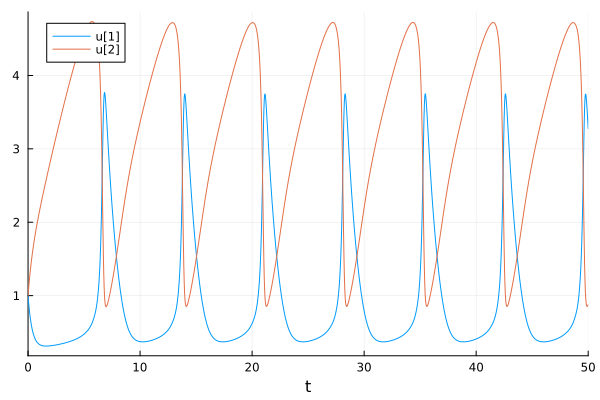

In [8]:
u0_b = [1.0, 1.0]
p_b = (1.0, 3.0)

prob_b = ODEProblem(brusselator!, u0_b, (0.0, 50.0), p_b)
sol_b = solve(prob_b, Tsit5())
plot(sol_b)

## Defining systems of "chemical equations" using Catalyst.jl


Many dynamical systems, such as population models in ecology or epidemic models can actually be described as sets of chemical equations. We can use the [Catalyst](https://docs.sciml.ai/Catalyst/stable/#doc_index_example) package, which relies on ModelingToolkit, to easily express such systems.

As an example, we'll implement the [Lotka-Volterra](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) model, which models an ecosystem with two species. A "prey" species (we'll use 🐇) and a "predator" species (we'll use 🦊). Each line in the `begin` block below specifies a reaction. The term before the comma is the reaction rate, and the expression to the right is the reaction.

In [9]:
lotka_volterra = @reaction_network begin
    α, 🐇 --> 2🐇
    β*🦊, 🐇 --> ∅
    γ, 🦊 --> ∅
    δ*🐇, 🦊 --> 2🦊  
end

Model ##ReactionSystem#240:
Unknowns (2): see unknowns(##ReactionSystem#240)
  🐇(t)
  🦊(t)
Parameters (4): see parameters(##ReactionSystem#240)
  α
  β
  γ
  δ

We can convert these chemical reactions to a set of differential equations and display them with LaTeX:

In [10]:
odes = convert(ODESystem, lotka_volterra)
latexify(odes)

L"\begin{align}
\frac{\mathrm{d} 🐇\left( t \right)}{\mathrm{d}t} &= 🐇\left( t \right) \alpha - 🐇\left( t \right) 🦊\left( t \right) \beta \\
\frac{\mathrm{d} 🦊\left( t \right)}{\mathrm{d}t} &=  - 🦊\left( t \right) \gamma + 🐇\left( t \right) 🦊\left( t \right) \delta
\end{align}
"

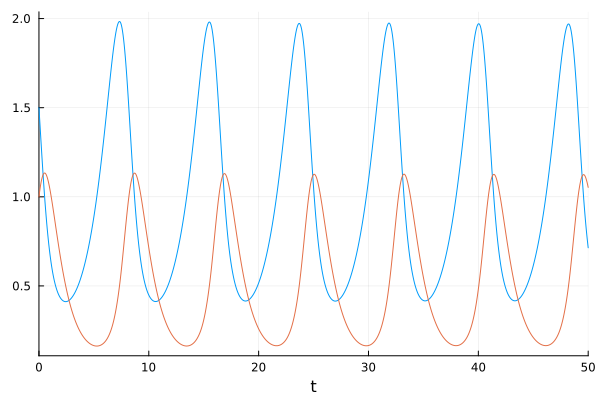

In [11]:
@parameters α β γ δ
@variables t 🐇(t) 🦊(t)

p = (
    α => 2/3,
    β => 4/3,
    γ => 1.0,
    δ => 1.0
)
u_0 = [
    🐇 => 1.5,
    🦊 => 1.0
]
tspan = (0.0,50.0)

prob = ODEProblem(lotka_volterra, u_0, tspan, p)

sol = solve(prob, Tsit5())
plot(sol, label="")

## Parameter estimation using Turing.jl


As our final example, we'll show how to use Turing, a Julia for Bayesian inference to estimate model parameters from noisy data. We'll use the well-known SIR model from epidemiology, which can actually be expressed as 2 chemical reactions.

In [12]:
sir = @reaction_network begin
    β, S + I --> 2*I
    γ, I --> R
end

Model ##ReactionSystem#248:
Unknowns (3): see unknowns(##ReactionSystem#248)
  S(t)
  I(t)
  R(t)
Parameters (2): see parameters(##ReactionSystem#248)
  β
  γ

In [13]:
sir_ode = convert(ODESystem, sir)
latexify(sir_ode)

L"\begin{align}
\frac{\mathrm{d} S\left( t \right)}{\mathrm{d}t} &=  - S\left( t \right) I\left( t \right) \beta \\
\frac{\mathrm{d} I\left( t \right)}{\mathrm{d}t} &=  - I\left( t \right) \gamma + S\left( t \right) I\left( t \right) \beta \\
\frac{\mathrm{d} R\left( t \right)}{\mathrm{d}t} &= I\left( t \right) \gamma
\end{align}
"

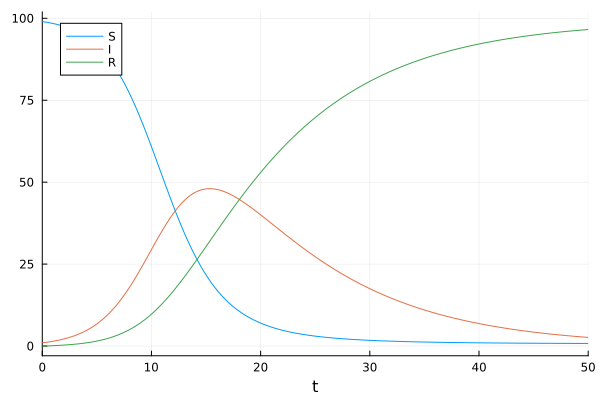

In [15]:
@parameters β γ
@variables t S(t) I(t) R(t)

p = (
    β => 0.005,
    γ => 0.1
)
u_0 = [
    S => 99.0,
    I => 1.0,
    R => 0.0
]
tspan = (0.0,50.0)

prob = ODEProblem(sir, u_0, tspan, p)
sol = solve(prob, Tsit5())

plot(sol)

Next we'll take the solution to our ODE and add some gaussian noise to it (This is not how actual epidemics are modeled in practice).

In [16]:
data = Array(sol(1:50)) .+ 2.0 * randn(3,50)

3×50 Matrix{Float64}:
 99.7573    95.7626     97.934    95.7808   …   3.16714   2.27206  -0.44798
 -0.868143   2.59612     5.12874   1.69709      6.70935   2.32447  -1.1861
  2.58053    0.0843901   3.74104   0.49019     97.4337   94.6114   94.4235

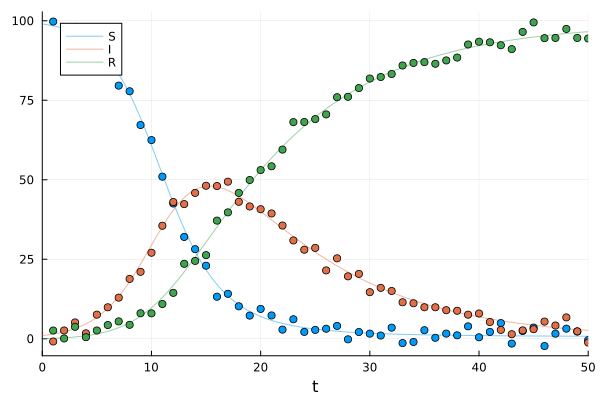

In [17]:
plot(sol, alpha = 0.5)
scatter!(1:50, data[1,:], color=1, label="")
scatter!(1:50, data[2,:], color=2, label="")
scatter!(1:50, data[3,:], color=3, label="")

The next cell defines our Bayesian model, which starts with assigning prior distributions to the parameter values, simulate the ODE with these parameters, and generate new noised data. That data is then compared with the original data to see how close it is. This is used to steer the parameters to obtain a better approximation of the true data.

The expression at the bottom of the cell repeats this process 4 times.

In [22]:
@model function fitmodel(data, ds)
    σ ~ InverseGamma(2,3)
    β ~ Uniform(0.0,0.01)
    γ ~ Uniform(0.0,0.2)

    p = (:β => β, :γ => γ)
    prob = remake(ds, p=p)
    predicted = solve(prob, Tsit5(), saveat=1:50)

    for i in length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitmodel(data, prob)
@time chain = mapreduce(c -> sample(model, NUTS(0.7), 2000), chainscat, 1:4)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/csimal/.julia/packages/Turing/Z4MFH/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:02:05
Sampling   1%|▍                                         |  ETA: 0:01:03
Sampling   2%|▋                                         |  ETA: 0:00:43
Sampling   2%|▉                                         |  ETA: 0:00:33
Sampling   2%|█                                         |  ETA: 0:00:26
Sampling   3%|█▎                                        |  ETA: 0:00:22
Sampling   4%|█▌                                        |  ETA: 0:00:19
Sampling   4%|█▋                                        |  ETA: 0:00:17
Sampling   4%|█▉                                        |  ETA: 0:00:16
Sampling   5%|██▏                                       |  ETA: 0:00:14
Sampling   6%|██▎                                       |  ETA: 0:00:13
Sampling   6

  9.265936 seconds (64.85 M allocations: 4.569 GiB, 8.76% gc time, 18.47% compilation time: 78% of which was recompilation)


Sampling 100%|██████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (2000×15×4 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 4
Samples per chain = 2000
Wall duration     = 8.49 seconds
Compute duration  = 8.43 seconds
parameters        = σ, β, γ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    3.0617    1.5226    0.0373   1903.4029   2100.4932    1.0022   ⋯
           β    0.0071    0.0015    0.0000   1433.5038   1650.6198    1.0021   ⋯
           γ    0.1329    0.0364    0.0009   1557.6367   1490.3883    1.0012   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%   

We can then plot the result. As we can see, it has trouble finding the correct parameter values. This is not surprising for the SIR model, especially as we're fitting it with gaussian noise.

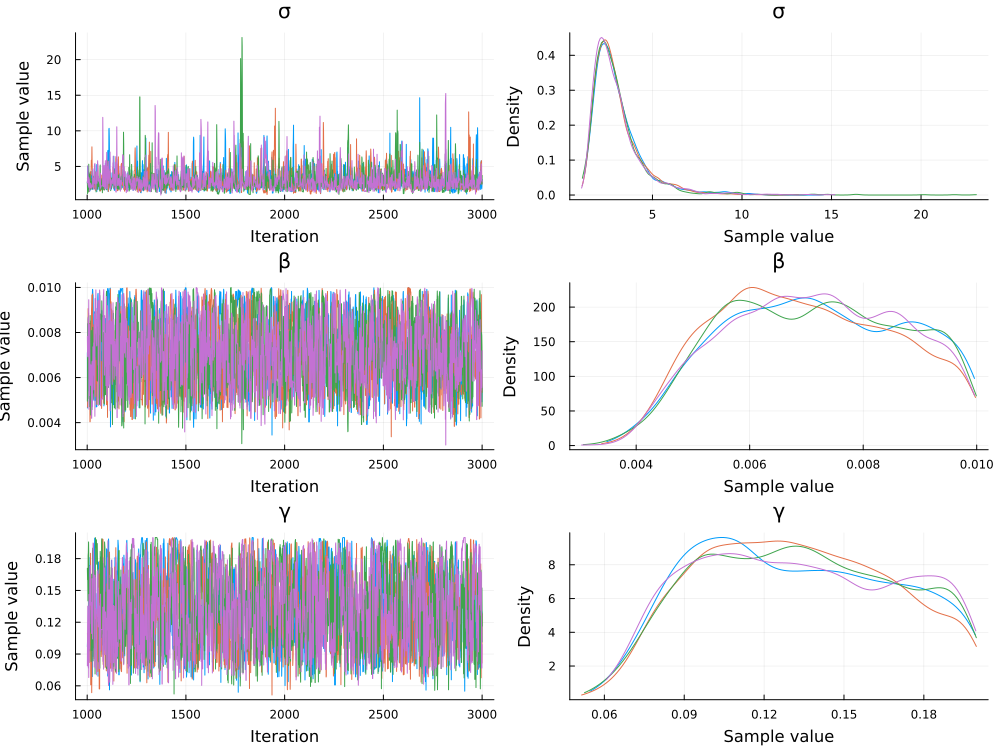

In [23]:
plot(chain)

## Exercise

Implement you favorite dynamical system using one of the methods shown here.